# Comparing Analysis Between Researchers

This notebook compares work done by Noam Michael and Jacob Bien to make sure our work is both reproducible and our methodology is well described.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import warnings

# Global Vars
MCQ_QSETS = ['LSAT-AR', 'SAT-EN', 'SciQ']
SC_COLS = ["Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E"]


# Suppress all warnings
warnings.filterwarnings('ignore')

# Or, suppress a specific type of warning
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Import DataFrames
raw_path = Path(r"Combined Results\combined_raw.csv")
clean_path = Path(r"Combined Results\combined_clean.csv")
jb_path = Path(r"Combined Results\llm-confidence-correct.csv")

combined_df = pd.read_csv(raw_path)
combined_clean = pd.read_csv(clean_path)
jb_df = pd.read_csv(jb_path)

# Summary Info

In [3]:
counts = pd.DataFrame({
    "Raw": combined_df["Question Set"].value_counts() / 11, # This is slightly below 2000 for Llama because we had to drop 3 duplicates
    "Filtered": combined_clean["Question Set"].value_counts() / 11
})

counts[~counts.index.isin(MCQ_QSETS)]

counts["Prop. Kept"] = counts["Filtered"] / counts["Raw"]
counts


,Raw,Filtered,Prop. Kept
Question Set,,,
BoolQ,3270.000000,2503.0,0.765443
HaluEval,1998.909091,1790.0,0.895488
LSAT-AR,229.909091,86.0,0.374061
LifeEval,808.000000,751.0,0.929455
SAT-EN,206.000000,173.0,0.839806
SciQ,1000.000000,995.0,0.995000


In [4]:
combined_df[combined_df["Coerce"] == True].pivot_table(index="Model", columns="Question Set",
                        aggfunc="size", fill_value=0)

Question Set,BoolQ,HaluEval,LSAT-AR,LifeEval,SAT-EN,SciQ
Model,,,,,,
Meta-Llama-3.1-70B-Instruct,3241,1960,208,807,202,1000
Meta-Llama-3.1-8B-Instruct,3200,1997,190,800,202,997
claude-3-7-sonnet-20250219,3267,2000,228,808,206,999
claude-3-haiku-20240307,3036,1855,230,808,181,999
claude-sonnet-4-20250514,3258,2000,188,808,205,1000
deepseek-r1,3214,2000,228,808,206,1000
deepseek-v3,2898,2000,228,808,204,1000
gemini-2.5-flash,3261,2000,177,808,206,1000
gemini-2.5-pro,3190,1984,188,808,204,1000


# Comparing DataFrames
---

We had some notable differences from Jacob's results in **LSAT-AR** and **SciQ**. Let's take a look.

In [5]:
sciq_filtered = combined_clean[combined_clean["Question Set"] == "SciQ"]
sciq_raw = combined_df[combined_df["Question Set"] == "SciQ"]


sciq_filtered_ids = sciq_filtered.index

deleted = sciq_raw[~sciq_raw.index.isin(sciq_filtered_ids)]
deleted["Question ID"].unique()

# Deleted QID in SciQ are ['13', '40', '295', '699', '705'] after visual inspection they all seem to have False coerce values in one of 11 rows


false_counts = (deleted['Coerce'].eq(False)
                .groupby(deleted['Question ID'])
                .sum()
                .rename('false_count'))

# as a DataFrame
false_counts = false_counts.reset_index()
false_counts = false_counts[false_counts['false_count'] != 0]
false_counts


,Question ID,false_count
35,13,1
218,295,1
335,40,1
666,699,1
674,705,1


Jacob's cleaned version of SciQ has 996 QIDs while mine has 995. When investigating each deleted Question ID in my version we find that they all have 1 instance where the answer could not be coerced. Does Jacob have an extra question that shouldn't be there?

---
Looking at LSAT-AR we see that Jacob had 87 QIDs while mine had 86. Let's investigate the difference.

In [6]:

lsat_filtered = combined_clean[combined_clean["Question Set"] == "LSAT-AR"]
lsat_raw = combined_df[combined_df["Question Set"] == "LSAT-AR"]


lsat_filtered_ids = lsat_filtered["Question ID"]

deleted = lsat_raw[~lsat_raw["Question ID"].isin(lsat_filtered_ids)]
deleted["Question ID"].unique()



false_counts = (deleted['Coerce'].eq(False)
                .groupby(deleted['Question ID'])
                .sum()
                .rename('false_count'))

# as a DataFrame
false_counts = false_counts.reset_index()

# There is one QID that was removed while having all coerce values as True. Lets investigate:
special_qid = list(false_counts[false_counts['false_count'] == 0]['Question ID'])
print(f"Special Question IDs: {special_qid}")

# At some point QID 64
bad_qid_confidence = lsat_raw[lsat_raw['Question ID'].isin(special_qid)][["Question ID", "Model", "Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E",]]#.sum(axis =1)

bad_qid_confidence['Sum'] = bad_qid_confidence.sum(axis=1, numeric_only = True)
display(bad_qid_confidence)
bad_qid_confidence.shape

Special Question IDs: ['64']


,Question ID,Model,Stated Confidence A,Stated Confidence B,Stated Confidence C,Stated Confidence D,Stated Confidence E,Sum
6142,64,claude-3-7-sonnet-20250219,0.050,0.050,0.050,0.05,0.800,1.0
13656,64,claude-3-haiku-20240307,0.000,0.000,0.500,0.50,0.000,1.0
21170,64,claude-sonnet-4-20250514,0.100,0.100,0.100,0.10,0.600,1.0
28684,64,deepseek-r1,0.000,0.000,0.000,1.00,0.000,1.0
36198,64,deepseek-v3,0.000,1.000,0.000,0.00,0.000,1.0
43712,64,gemini-2.5-flash,0.050,0.050,0.050,0.80,0.050,1.0
51226,64,gemini-2.5-pro,0.005,0.005,0.005,0.98,0.005,1.0
58740,64,gpt-4o,0.100,0.700,0.050,0.10,0.050,1.0
73758,64,Meta-Llama-3.1-70B-Instruct,0.000,0.000,1.000,0.00,0.000,1.0
81269,64,Meta-Llama-3.1-8B-Instruct,0.800,0.900,0.800,0.90,0.900,4.3


(10, 8)

Question ID 64 in LSAT-AR only had 10 answered instances. Notably, GPT-o3 failed to respond. Because of this, we dropped it from the analysis.

In [7]:

## SciQ
jb_qid = jb_df[jb_df["qset"] == "sciq_test"]["question_id"].unique()
my_qid = combined_clean[combined_clean["Question Set"] == "SciQ"]["Question ID"].unique()

# elements not in the intersection (i.e., in exactly one array)
not_in_intersection = np.setxor1d(jb_qid, my_qid)

# if you also want side-specific lists:
only_in_jb = np.setdiff1d(jb_qid, my_qid)
only_in_me = np.setdiff1d(my_qid, jb_qid)

only_in_jb


## LSAT-AR
jb_qid = jb_df[jb_df["qset"] == "lsat_ar_test"]["question_id"].unique()
my_qid = combined_clean[combined_clean["Question Set"] == "LSAT-AR"]["Question ID"].unique()

# elements not in the intersection (i.e., in exactly one array)
not_in_intersection = np.setxor1d(jb_qid, my_qid)

# if you also want side-specific lists:
only_in_jb = np.setdiff1d(jb_qid, my_qid)
only_in_me = np.setdiff1d(my_qid, jb_qid)

print(f"Unique Question IDs for LSAT-AR in Jacob's Work: {only_in_jb}")

Unique Question IDs for LSAT-AR in Jacob's Work: ['1' '102' '110' '111' '113' '114' '116' '117' '118' '119' '12' '120'
 '121' '124' '125' '126' '129' '13' '133' '134' '136' '137' '138' '140'
 '143' '146' '148' '149' '150' '151' '152' '153' '154' '156' '157' '158'
 '159' '161' '164' '165' '167' '168' '169' '170' '171' '173' '174' '175'
 '176' '177' '179' '18' '183' '186' '187' '188' '19' '190' '191' '192'
 '193' '194' '195' '196' '197' '198' '199' '200' '201' '206' '208' '209'
 '21' '210' '214' '215' '217' '218' '22' '221' '223' '224' '225' '226'
 '227' '229' '23' '25' '26' '28' '31' '32' '33' '34' '36' '37' '38' '39'
 '40' '41' '42' '44' '45' '46' '47' '48' '49' '50' '51' '52' '54' '55'
 '56' '57' '58' '59' '6' '60' '62' '63' '64' '65' '66' '67' '68' '69' '70'
 '72' '74' '76' '78' '79' '80' '81' '82' '83' '84' '85' '86' '9' '92' '93'
 '96' '98']


In [8]:
## ECE function

def get_ece(s: pd.Series, c: pd.Series, n_bins: int = 10):
    # Ensure inputs are clean
    global score, confidence
    score = s.copy().astype(float)#.reset_index().drop('index', axis = 1)
    confidence = c.copy().astype(float)#.reset_index().drop('index', axis = 1)

    # Bin edges and assignments
    global bin_edges, bin_ids
    bin_edges = np.union1d(
        np.linspace(0.0, 1.0, n_bins + 1), 
        np.array([1.00001])
        )
    bin_ids = np.digitize(confidence, bin_edges, right=False)

    ece = 0.0
    total_count = len(score)

    # Calculate ECE per bin
    for i in range(1, n_bins + 1 ):
        bin_mask = bin_ids == i
        bin_count = bin_mask.sum()
        
        if bin_count > 0:
            bin_accuracy = score[bin_mask].mean()
            bin_confidence = confidence[bin_mask].mean()
            bce = (bin_count / total_count) * abs(bin_accuracy - bin_confidence) #Bin Calibration Error
            #print(f"Bin {i} CE: {bce}")
            ece += bce 

    return ece

# Create Summary DataFrame

In [9]:
sum_df = pd.DataFrame(columns= ["Question Set", "Model", "Accuracy", "ECE", "Confidence", "Overconfidence", "Gini", "GiniECE"])
all_qset_names = combined_clean["Question Set"].unique()
all_model_names = combined_clean["Model"].unique()


for qset_name in all_qset_names:
    for model_name in all_model_names:
        df  = combined_clean[(combined_clean['Question Set'] == qset_name) & (combined_clean['Model'] == model_name)].reset_index()

        if qset_name in MCQ_QSETS:
            s = df["Score"].astype(float)
            c = df["Stated Confidence Answer (MCQ)"].astype(float)
            #g = df['gini'].astype(float)
            #gece = get_ece(s, g)
        else:
            s = df["Score"].astype(float)
            c = df["Stated Confidence Answer"].astype(float)
            #gece = None
            #g = pd.Series([0])

        ece = get_ece(s, c)

        oc = c.mean() - s.mean()
        row = {
            "Question Set": qset_name,
            "Model": model_name,
            "Accuracy": s.mean(),
            "ECE": ece,
            "Confidence": c.mean(),
            "Overconfidence": oc,
            #"Gini": g.mean(),
            #"GiniECE": gece
        }

        sum_df.loc[len(sum_df)] = row



sum_df[sum_df["Question Set"].isin(['SAT-EN'])]
sum_df

,Question Set,Model,Accuracy,ECE,Confidence,Overconfidence,Gini,GiniECE
0,BoolQ,Claude-Sonnet-3.7,0.831402,0.123539,0.955741,0.124338,NaN,NaN
1,BoolQ,Claude Haiku 3,0.781462,0.116728,0.897631,0.116169,NaN,NaN
2,BoolQ,Claude-Sonnet-4,0.842988,0.076904,0.919732,0.076744,NaN,NaN
3,BoolQ,DeepSeek-R1,0.844986,0.110276,0.956061,0.111075,NaN,NaN
4,BoolQ,DeepSeek-V3,0.829005,0.097823,0.929425,0.100419,NaN,NaN
...,...,...,...,...,...,...,...,...
61,SciQ,Gemini-2.5-Pro,0.975879,0.025118,0.954440,-0.021439,NaN,NaN
62,SciQ,GPT-4o,0.968844,0.052141,0.919517,-0.049327,NaN,NaN
63,SciQ,GPT-o3,0.980905,0.154412,0.826492,-0.154412,NaN,NaN
64,SciQ,Llama-3.1-70B,0.953769,0.027106,0.946764,-0.007005,NaN,NaN


In [10]:
# Coloring 

family_palettes = {
    "GPT":      sns.color_palette("Greens", 6),
    "Claude":   sns.color_palette("Blues", 6),
    "Gemini":   sns.color_palette("Purples", 6),
    "DeepSeek": sns.color_palette("Oranges", 6),
    "Llama":    sns.color_palette("RdPu", 6),
}


melted_dict = {}
# --- Function Definitions ---
def model_family(name: str) -> str:
    s = name.lower()
    if "gpt" in s or "o3" in s:   return "GPT"
    if "claude" in s:             return "Claude"
    if "gemini" in s:             return "Gemini"
    if "deepseek" in s:           return "DeepSeek"
    if "llama" in s:              return "Llama"
    return "other"


def pick_color(name: str) -> tuple:
    fam = model_family(name)
    pal = family_palettes[fam]
    s = name.lower()
    # Prefer consistent shades for common variants:
    if fam == "GPT":
        if "gpt-4o" in s: return pal[-2]  # darker green
        if "o3" in s:     return pal[1]   # lighter green
    if fam == "Claude":
        if "sonnet" in s: return pal[-2]
        if "haiku"  in s: return pal[2]
    if fam == "Gemini":
        if "pro"   in s:  return pal[-2]
        if "flash" in s:  return pal[2]
    if fam == "DeepSeek":
        if "r1"   in s:  return pal[-2]
        if "v3" in s:  return pal[2]
    return pal[3]  # default mid shade

In [11]:
cc = combined_clean.copy()
cc = cc[(cc['Question Set'] == 'LSAT-AR') & (cc['Model'] == 'Gemini-2.5-Pro')]
cc

ts = cc['Score']
tc = cc['Stated Confidence Answer (MCQ)']

print(f"ECE:  {get_ece(ts, tc)}")
bin_ids

for i in np.unique(bin_ids):
    mask = bin_ids == i

    mus = ts[mask].mean()
    muc = tc[mask].mean()
    print('-'*64)
    print(f"Count for bin {i}:            {mask.sum()}")
    print(f"Mean Score for Bin {i}:       {mus}")
    print(f"Mean Confidence for Bin {i}:  {muc}")


tc[bin_ids == 10]

cc[bin_ids == 10][['Stated Confidence Answer (MCQ)','Stated Confidence A', 'Stated Confidence B', 'Stated Confidence C', 'Stated Confidence D', 'Stated Confidence E']]#.dtypes

cc['Stated Confidence Answer (MCQ)'].value_counts()

ECE:  0.008488372093023297
----------------------------------------------------------------
Count for bin 10:            57
Mean Score for Bin 10:       0.9824561403508771
Mean Confidence for Bin 10:  0.9696491228070174
----------------------------------------------------------------
Count for bin 11:            29
Mean Score for Bin 11:       0.9310344827586207
Mean Confidence for Bin 11:  1.0


Stated Confidence Answer (MCQ)
1.00    29
0.98    26
0.96    23
0.95     3
0.99     2
0.97     2
0.94     1
Name: count, dtype: int64

# Compare Values

## Compare ECE

,Question Set,Model,Accuracy,ECE,Confidence,Overconfidence,Gini,GiniECE,name,qset,llm,num_tot,ece,accuracy,confidence,avg_gini,overconfidence,diff
16,LifeEval,Claude-Sonnet-3.7,0.544942,0.039941,0.531105,-0.013837,NaN,NaN,LifeEvalClaude-Sonnet-3.7,LifeEval,Claude-Sonnet-3.7,751,0.041991,0.560177,0.531105,NaN,-0.029072,0.015235
17,LifeEval,Claude-Sonnet-4,0.539776,0.066223,0.497909,-0.041866,NaN,NaN,LifeEvalClaude-Sonnet-4,LifeEval,Claude-Sonnet-4,751,0.065852,0.562515,0.497909,NaN,-0.064606,0.022740
18,LifeEval,DeepSeek-R1,0.544324,0.032770,0.572344,0.028020,NaN,NaN,LifeEvalDeepSeek-R1,LifeEval,DeepSeek-R1,751,0.023820,0.561326,0.572344,NaN,0.011018,0.017002
19,LifeEval,DeepSeek-V3,0.532636,0.124056,0.637217,0.104581,NaN,NaN,LifeEvalDeepSeek-V3,LifeEval,DeepSeek-V3,751,0.102203,0.559457,0.637217,NaN,0.077760,0.026821
20,LifeEval,Gemini-2.5-Flash,0.537868,0.097951,0.635820,0.097951,NaN,NaN,LifeEvalGemini-2.5-Flash,LifeEval,Gemini-2.5-Flash,751,0.079789,0.559134,0.635820,NaN,0.076686,0.021266
21,LifeEval,Gemini-2.5-Pro,0.538403,0.024932,0.534193,-0.004210,NaN,NaN,LifeEvalGemini-2.5-Pro,LifeEval,Gemini-2.5-Pro,751,0.025144,0.559279,0.534193,NaN,-0.025086,0.020876
22,LifeEval,GPT-4o,0.545491,0.085002,0.597670,0.052178,NaN,NaN,LifeEvalGPT-4o,LifeEval,GPT-4o,751,0.068043,0.557286,0.597670,NaN,0.040384,0.011795
23,LifeEval,GPT-o3,0.542480,0.030948,0.541340,-0.001140,NaN,NaN,LifeEvalGPT-o3,LifeEval,GPT-o3,751,0.028834,0.558947,0.541340,NaN,-0.017607,0.016467
26,LSAT-AR,DeepSeek-R1,0.953488,0.002791,0.997209,0.043721,NaN,NaN,LSAT-ARDeepSeek-R1,LSAT-AR,DeepSeek-R1,87,0.034023,0.965517,0.997241,0.005277,0.031724,0.011997


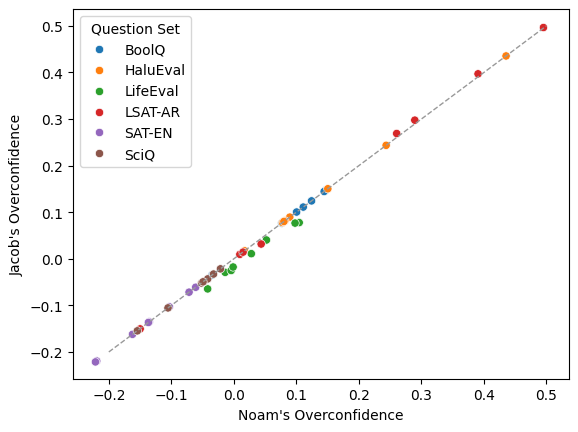

In [13]:
j = pd.read_csv(r"MISC\table1-info.csv")
d = sum_df.copy()
qset_order = ["BoolQ", "HaluEval", "LifeEval", "LSAT", "SAT", "SciQ"]  # edit as needed

j["qset"] = pd.Categorical(j["qset"], categories=qset_order, ordered=True)

j['qset'] = j['qset'].cat.rename_categories({"LSAT": "LSAT-AR", "SAT": "SAT-EN"})

j['name'] = j['qset'].astype(str) + j['llm'].astype(str) 
d['name'] = d['Question Set'] + d['Model']

merged = pd.merge(d,j , on = "name", suffixes= ['_noam', '_jacob'])
merged['diff'] = merged['Overconfidence'] - merged['overconfidence']

display(merged[abs(merged['diff']) > 0.01]) # These are all the instances where Jacob and I disagree (some very small differences exist due to FPA)

ax = sns.scatterplot(data = merged, x ="Overconfidence", y = "overconfidence", hue = "Question Set")
plt.xlabel("Noam's Overconfidence")
plt.ylabel("Jacob's Overconfidence")
lo = -0.2
hi = 0.5
ax.plot([lo, hi], [lo, hi], ls="--", c="0.6", lw=1) 
plt.show()


## Compare ECE

,Question Set,Model,Accuracy,ECE,Confidence,Overconfidence,Gini,GiniECE,name,qset,llm,num_tot,ece,accuracy,confidence,avg_gini,overconfidence,diff
4,BoolQ,Gemini-2.5-Flash,0.845386,0.052964,0.993036,0.147651,NaN,NaN,BoolQGemini-2.5-Flash,BoolQ,Gemini-2.5-Flash,2503,0.147651,0.845386,0.993036,0.013058,0.147651,-0.094686
5,BoolQ,Gemini-2.5-Pro,0.848981,0.075394,0.993492,0.144511,NaN,NaN,BoolQGemini-2.5-Pro,BoolQ,Gemini-2.5-Pro,2503,0.145310,0.848981,0.993492,0.012242,0.144511,-0.069916
9,HaluEval,Claude-Sonnet-4,0.521229,0.231061,0.956760,0.435531,NaN,NaN,HaluEvalClaude-Sonnet-4,HaluEval,Claude-Sonnet-4,1790,0.449497,0.521229,0.956760,NaN,0.435531,-0.218436
10,HaluEval,DeepSeek-R1,0.521229,0.059140,0.610715,0.089486,NaN,NaN,HaluEvalDeepSeek-R1,HaluEval,DeepSeek-R1,1790,0.120369,0.521229,0.610715,NaN,0.089486,-0.061229
12,HaluEval,Gemini-2.5-Flash,0.521229,0.056112,0.602872,0.081642,NaN,NaN,HaluEvalGemini-2.5-Flash,HaluEval,Gemini-2.5-Flash,1790,0.125721,0.521229,0.602872,NaN,0.081642,-0.069609
13,HaluEval,Gemini-2.5-Pro,0.521229,0.036788,0.601369,0.080140,NaN,NaN,HaluEvalGemini-2.5-Pro,HaluEval,Gemini-2.5-Pro,1790,0.126732,0.521229,0.601369,NaN,0.080140,-0.089944
19,LifeEval,DeepSeek-V3,0.532636,0.124056,0.637217,0.104581,NaN,NaN,LifeEvalDeepSeek-V3,LifeEval,DeepSeek-V3,751,0.102203,0.559457,0.637217,NaN,0.077760,0.021853
20,LifeEval,Gemini-2.5-Flash,0.537868,0.097951,0.635820,0.097951,NaN,NaN,LifeEvalGemini-2.5-Flash,LifeEval,Gemini-2.5-Flash,751,0.079789,0.559134,0.635820,NaN,0.076686,0.018162
22,LifeEval,GPT-4o,0.545491,0.085002,0.597670,0.052178,NaN,NaN,LifeEvalGPT-4o,LifeEval,GPT-4o,751,0.068043,0.557286,0.597670,NaN,0.040384,0.016959
24,LSAT-AR,Claude-Sonnet-3.7,0.418605,0.367442,0.809302,0.390698,NaN,NaN,LSAT-ARClaude-Sonnet-3.7,LSAT-AR,Claude-Sonnet-3.7,87,0.397126,0.413793,0.810920,0.296608,0.397126,-0.029685


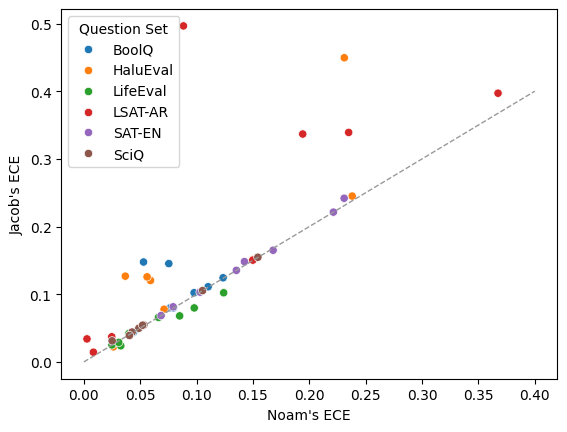

In [14]:
j['qset'] = j['qset'].cat.rename_categories({"LSAT": "LSAT-AR", "SAT": "SAT-EN"})

j['name'] = j['qset'].astype(str) + j['llm'].astype(str) 
d['name'] = d['Question Set'] + d['Model']

merged = pd.merge(d,j ,on = "name", suffixes= ['_noam', '_jacob'])
merged['diff'] = merged['ECE'] - merged['ece']

display(merged[abs(merged['diff']) > 0.01]) # These are all the instances where Jacob and I disagree (some very small differences exist due to FPA)

ax = sns.scatterplot(data = merged, x ="ECE", y = "ece", hue = "Question Set")
plt.xlabel("Noam's ECE")
plt.ylabel("Jacob's ECE")
lo = 0.0
hi = 0.4
ax.plot([lo, hi], [lo, hi], ls="--", c="0.6", lw=1) 
plt.show()


Although we have the same average confidence and accuracy for HaluEval, we differ on ECE scores. I wonder why?

I always inlcude the lowest value (e.g. [0.1, 0.2)

It seems that Jacob uses `confidence_bin = cut(stated_confidence, breaks = 10)` in order to slice up the bins. I think in my implementation I added an additional bin for [1.0] leading to 11 bins while Jacob has 10. This may be the reason for differing results when looking at ECE.

In [17]:
jb_df["qset"].unique()

array(['boolq_valid', 'lsat_ar_test', 'sat_en', 'sciq_test',
       'halu_eval_qa'], dtype=object)

In [16]:
jb_df[jb_df["qset"] == "life_eval"]

,llm,qset,question_id,stated_confidence,chosen_token_confidence,max_token_confidence,correct
